####  Download the CSV file from kaggle using Kaggle API

In [5]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('uciml/sms-spam-collection-dataset/', path='data', unzip=True)

#### Read The downloaded CSV file

In [55]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
  
df = pd.read_csv('data/spam.csv', encoding="ISO-8859-1")
print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (5572, 5)


### Disply firt 5 rows of dataframe

In [56]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Exploratory Data Analysis
1. Remove Unwanted columns
2. Convert Target column from string to interger for binary classification
3. Check for null values if present replace it 
4. check for duplicate values if present remove duplicate

In [57]:
updated_df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [58]:
updated_df.head()


,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [59]:
model_feature = 'v2'
model_target = 'v1'

In [60]:
updated_df['v1'].replace({"ham": 0, "spam": 1}, inplace=True)

In [61]:
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [62]:
updated_df.isnull().sum()

v1    0
v2    0
dtype: int64

In [67]:
updated_df.duplicated(subset=['v2']).sum()

403

In [71]:
updated_df= updated_df.drop_duplicates()

In [72]:
updated_df.shape

(5169, 2)

####  Text Processing

1. Convert features type Object  to str
2. Get the Stop words using stop_words libary for english language
3. Perform text cleaning by removing HTML tags, special char, punctuation, white space and lower case the text.

In [73]:
updated_df[model_feature] = updated_df[model_feature].astype('str')

In [74]:
from stop_words import get_stop_words

stop_words = get_stop_words('english')

In [10]:
print(stop_words)

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 'the', 'their', 'theirs', 'them', 'themselves', 't

In [75]:
import re, string
import nltk
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup

stemmer = SnowballStemmer('english')

def preProcessText(text):
    # Remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # Remove special characters and digits
    text = re.sub(r"[^a-zA-Z]", " ", text)
    
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    #lowercase and strip white space
    text = text.lower().strip()

   
    return text

def lexiconProcess(text, stop_words, stemmer):
    # fill in here
    filtered_sentence = []
    words = text.split(" ")
    for w in words:
        if w not in stop_words:
            filtered_sentence.append(stemmer.stem(w))

    text = " ".join(filtered_sentence)
    return text

def cleanSentence(text, stop_words, stemmer):
    return lexiconProcess(preProcessText(text), stop_words, stemmer)

# Clean the text features
for c in [model_feature]:
    print('Text cleaning: ', c)
    updated_df[c] = [cleanSentence(item, stop_words, stemmer) for item in updated_df[c].values]

Text cleaning:  v2


### Train, Test data creation and Target balancing

In [76]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(updated_df, test_size=0.1, shuffle=True, random_state=42)

In [77]:
print(train_data.shape)
print(test_data.shape)

(4652, 2)
(517, 2)


#### Target distribution 

In [78]:
updated_df[model_target].value_counts()

v1
0    4516
1     653
Name: count, dtype: int64

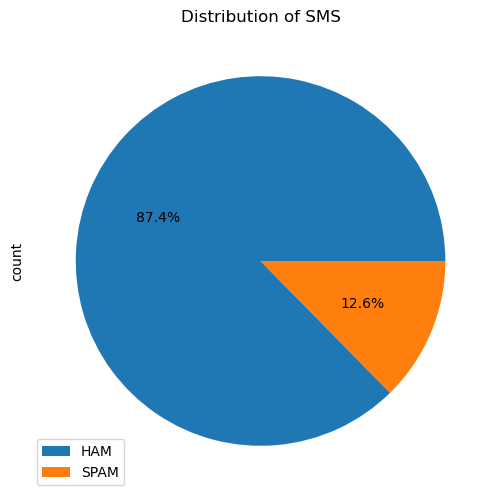

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
updated_df[model_target].value_counts().plot.pie(figsize=(6,6),title="Distribution of SMS",labels=['',''],autopct='%1.1f%%')
labels=["HAM","SPAM"]
plt.legend(labels,loc=3)


In [86]:
print('Training set shape:', train_data.shape)

print('Class ham samples in the training set:', sum(train_data[model_target] == 0))
print('Class spam samples in the training set:', sum(train_data[model_target] == 1))

print('')

print('Test set shape:', test_data.shape)

print('Class ham samples in the test set:', sum(test_data[model_target] == 0))
print('Class spam samples in the test set:', sum(test_data[model_target] == 1))


Training set shape: (4652, 2)
Class ham samples in the training set: 4073
Class spam samples in the training set: 579

Test set shape: (517, 2)
Class ham samples in the test set: 443
Class spam samples in the test set: 74


In [90]:
class_ham_no = train_data[train_data[model_target] == 0]
class_spam_no = train_data[train_data[model_target] == 1]

In [93]:
from sklearn.utils import resample
from sklearn.utils import shuffle

upsampled = resample(class_spam_no, replace=True, n_samples = 4652)
downsampled = resample(class_ham_no, replace=False, n_samples=4652)

train_data = pd.concat([downsampled, upsampled])
train_data = shuffle(train_data)

In [94]:
print('Training set shape:', train_data.shape)

print('Class ham samples in the training set:', sum(train_data[model_target] == 0))
print('Class spam samples in the training set:', sum(train_data[model_target] == 1))

print('')


Training set shape: (9304, 2)
Class ham samples in the training set: 4652
Class spam samples in the training set: 4652



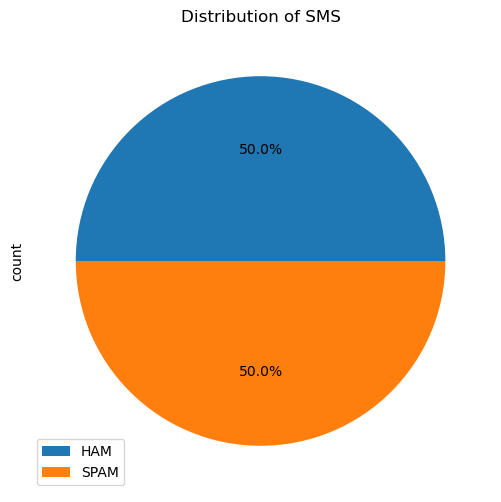

In [95]:
train_data[model_target].value_counts().plot.pie(figsize=(6,6),title="Distribution of SMS",labels=['',''],autopct='%1.1f%%')
labels=["HAM","SPAM"]
plt.legend(labels,loc=3)

### Visualization Of text data based on target values using word cloud

In [96]:
from wordcloud import WordCloud

wc = WordCloud(width=600, height=500, min_font_size=12, background_color="white")

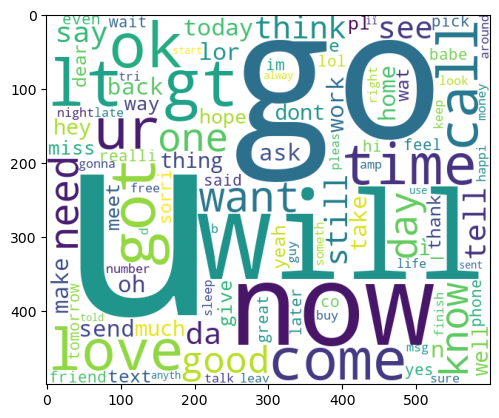

In [99]:
ham_wc = wc.generate(updated_df[updated_df[model_target]==0][model_feature].str.cat(sep=" "))
plt.imshow(ham_wc)

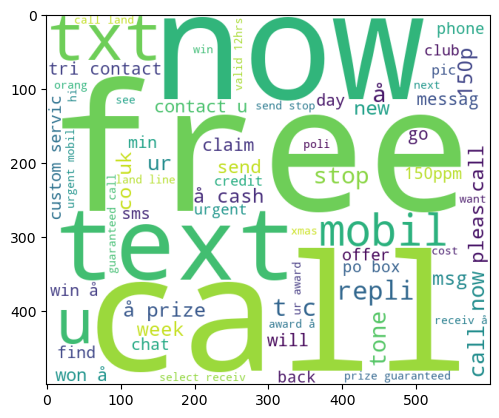

In [100]:
spam_wc = wc.generate(updated_df[updated_df[model_target]==1][model_feature].str.cat(sep=" "))
plt.imshow(ham_wc)

### Pipeline 
1. Used TfidfVectorizer for text vectorization
2. Used bagging classifier with defualt values

In [101]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

text_processor_0 = Pipeline([
    ('text_vect_0', TfidfVectorizer(use_idf=True, max_features=50)) ])

pipeline = Pipeline([
    ('data_preprocessing', text_processor_0),
    ('BGClf', BaggingClassifier())
])    

from sklearn import set_config
set_config(display='diagram')
pipeline

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('text_vect_0',
                                  TfidfVectorizer(max_features=50))])),
                ('BGClf', BaggingClassifier())])

### Parameter Tuning and Model Evaluation

In [102]:
from sklearn.metrics import confusion_matrix

X_train = train_data[model_feature]
y_train = train_data[model_target]

# Fit the Pipeline to training data
pipeline.fit(X_train, y_train)

# Use the fitted pipeline to make predictions on the train dataset
train_predictions = pipeline.predict(X_train)
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Accuracy (training):", accuracy_score(y_train, train_predictions))

# Get test data to test the pipeline
X_test = test_data[model_feature]
y_test = test_data[model_target]

# Use the fitted pipeline to make predictions on the test dataset
test_predictions = pipeline.predict(X_test)
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("Accuracy (test):", accuracy_score(y_test, test_predictions))

[[4511  141]
 [ 210 4442]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4652
           1       0.97      0.95      0.96      4652

    accuracy                           0.96      9304
   macro avg       0.96      0.96      0.96      9304
weighted avg       0.96      0.96      0.96      9304

Accuracy (training): 0.962274290627687
[[423  20]
 [ 10  64]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       443
           1       0.76      0.86      0.81        74

    accuracy                           0.94       517
   macro avg       0.87      0.91      0.89       517
weighted avg       0.95      0.94      0.94       517

Accuracy (test): 0.941972920696325


### Below graph shows the ROC curve for bagging classifoer which is descision tree by default and the AUC value is 0.93 before hyper tuning the model

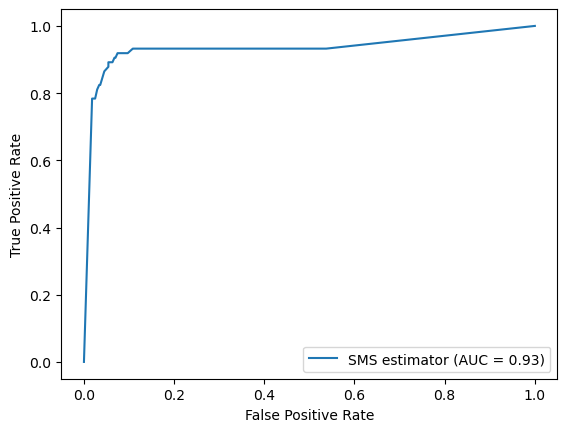

In [122]:
from sklearn.metrics import roc_curve,roc_auc_score,RocCurveDisplay

test_predictions_1 = pipeline.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_1[:,1],pos_label=1)
roc_auc = roc_auc_score(y_test, test_predictions_1[:,1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='SMS estimator')
display.plot()
plt.show()

### Hypertune the parameters

In [103]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , LinearRegression


### PIPELINE GRID_SEARCH ###
############################

# Parameter grid for GridSearch
param_grid={ 'BGClf__estimator' :[SVC(),SGDClassifier(),LinearRegression()],
             'BGClf__n_estimators': [5,10,15,20]
           }

grid_search = GridSearchCV(pipeline, # Base model
                           param_grid, # Parameters to try
                           cv = 3, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors
                          )

# Fit the GridSearch to our training data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/opt/miniconda3/envs/my_default_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/miniconda3/envs/my_default_env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/miniconda3/envs/my_default_env/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
  File "/opt/miniconda3/envs/my_default_env/lib/python3.9/site-packages/sklearn/pipeline.py", line 753, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
  File "/opt/miniconda3/envs/my_default_env/lib/python3.9/site-packages/sklearn/base.py", line 705, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "/opt/miniconda3/envs/my_defa

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('data_preprocessing',
                                        Pipeline(steps=[('text_vect_0',
                                                         TfidfVectorizer(max_features=50))])),
                                       ('BGClf', BaggingClassifier())]),
             n_jobs=-1,
             param_grid={'BGClf__estimator': [SVC(), SGDClassifier(),
                                              LinearRegression()],
                         'BGClf__n_estimators': [5, 10, 15, 20]},
             verbose=1)

In [104]:
classifier = grid_search.best_estimator_
print(classifier)
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions)) 

Pipeline(steps=[('data_preprocessing',
                 Pipeline(steps=[('text_vect_0',
                                  TfidfVectorizer(max_features=50))])),
                ('BGClf', BaggingClassifier(estimator=SVC()))])
Model performance on the train set:
[[4524  128]
 [ 250 4402]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      4652
           1       0.97      0.95      0.96      4652

    accuracy                           0.96      9304
   macro avg       0.96      0.96      0.96      9304
weighted avg       0.96      0.96      0.96      9304

Train accuracy: 0.959372312983663


In [105]:
test_predictions = classifier.predict(X_test)

print('Model performance on the test set:')
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))
print("test accuracy:", accuracy_score(y_test, test_predictions)) 

Model performance on the test set:
[[428  15]
 [  5  69]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       443
           1       0.82      0.93      0.87        74

    accuracy                           0.96       517
   macro avg       0.90      0.95      0.93       517
weighted avg       0.96      0.96      0.96       517

test accuracy: 0.9613152804642167


### After hyper tuning the parameters SVC is the best estimator for this model and as shown in the below graph AUC for the given model is .96 which is increase in 3% before the hypertuning.

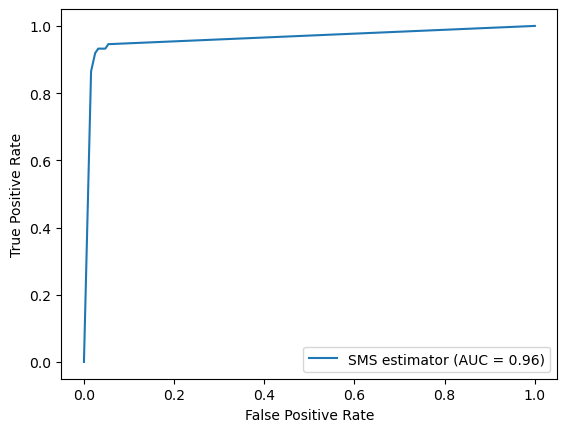

In [121]:
from sklearn.metrics import roc_curve,roc_auc_score,RocCurveDisplay

test_predictions_1 = classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_1[:,1],pos_label=1)
roc_auc = roc_auc_score(y_test, test_predictions_1[:,1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='SMS estimator')
display.plot()
plt.show()